Ce notebook contient des essais généraux concernant la descente de gradient.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

sigma = 1 / np.sqrt(2)
two_sigma_squared = 2 * sigma * sigma

Afin d'effectuer les tests, on place la grille des $z_k$ et on choisit les $\alpha_k$ de manière aléatoire.

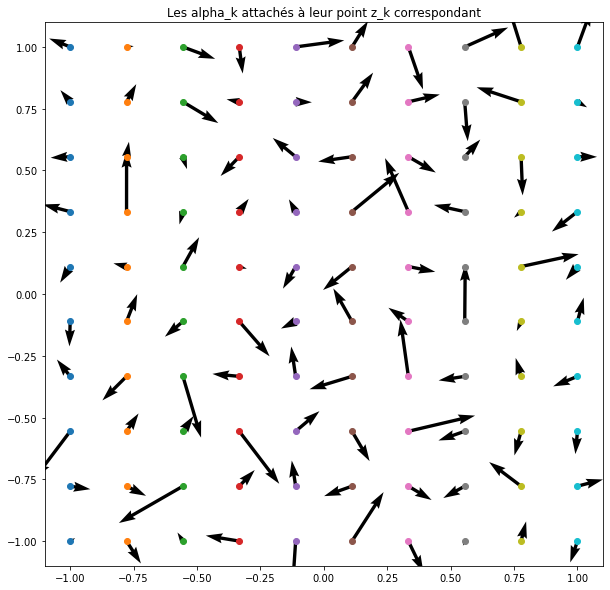

In [2]:
pas = 0.2
gauche = -1.0
droite = 1
h = int((droite - gauche)/pas)

D = h * h
zk_x, zk_y = np.meshgrid(np.linspace(gauche, droite, h),np.linspace(gauche, droite, h))
alphas_x = np.random.randn(h, h)
alphas_y = np.random.randn(h, h)

zk = np.array((zk_x.flatten(), zk_y.flatten())).T
alphas = np.array((alphas_x.flatten(), alphas_y.flatten())).T
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(zk_x, zk_y, marker= 'o', linestyle='none');
plt.quiver(zk_x, zk_y, alphas_x, alphas_y)
plt.title("Les alpha_k attachés à leur point z_k correspondant")
plt.show()

Ensuite, implémentons un algorithme de descente de gradient. On utilise les méthodes suivantes :
  - approximation du gradient par la formule $$ \frac{\partial f}{\partial x_i} (a) \approx \frac{f(a + \varepsilon e_i) - f(a)}{\varepsilon}$$
  avec $\varepsilon$ petit.
  - Recherche linéaire simple pour choisir le learning rate à chaque étape.
  

In [3]:
import time

def gradient_descent(f, start, dim, iterations=1000, epsilon=0.0001, learning_rate_guess=10.0,print_value=False):
    """Applique une descente de gradient à la fonctionnelle f en partant du point start.
    
    f est une fonctionne réelle de dim variables.
    
    Le gradient est approximé au premier ordre avec le pas epsilon fourni.
    
    Le learning_rate est recherché en partant du learning_rate_guess initial donné puis en divisant par 2 jusqu'à ce que la valeur à minimiser diminue effectivement.
    """
    if len(start) != dim:
        raise Exception("starting point must have right dimensions")

    # descent point
    point = start;
    # initialise gradient var
    grad = np.array([0.0] * dim)
    # canonical base: e[0] = (1, 0, 0, ...) and e[dim - 1] = (0, 0, ..., 1).
    e = np.identity(dim)
    
    tau = 0.5
    
    for i in range(iterations):
        # evaluate just one time at the current point
        value = f(point);
        
        if print_value:
            print("[GD] pass = ", i, "; value =", value)
            start_time = time.time()
        
        # roughly estimate gradient
        # df/dx_i (a) = (f(a + epsilon * e_i) - f(a)) / epsilon
        for d in range(dim):
            grad[d] = (f(point + epsilon * e[d]) - f(point)) / epsilon;
            


        # initial guess for learning rate
        l = learning_rate_guess
        
        while (value - f(point - l * grad)) < 0:
            l = tau * l;

        # apply learning rate
        point -= l * grad;
        
        if print_value:
            print("done in", (time.time()-start_time), "seconds")

    # fin boucle gradient
    return point;

On veut maintenant appliquer la descente de gradient à notre fonctionnelle J $$J(v) = |v|^2 + \lambda D(\varphi_v(S), T)$$

Un élément $v$ sera encodé par ses coordonnées dans la base évoquée à la question 6 : $$v = \sum_{0 \leq k < D} v_k E_k, \text{  } v_k \in \mathbb{R}$$
    avec $$E_k(x) = \alpha_k e^{-|x - z_k|^2}$$

L'espace vectoriel $V$ est donc de dimension $D$, le nombre de $(z_k)$, ce qui sera donc la dimension utilisée pour la descente de gradient.

On implémente la fonction $\varphi_v$ ainsi que l'image directe par celle-ci.

In [4]:
from hausdorff import hausdorff_distance

# Calcule phi_v(point), point étant un point de l'espace ambiant
def phi_point(v, point):
    result = np.copy(point) # on ne veut pas modifier la référence...
    for i in range(D):
        # z est un point de la grille, alpha le vecteur associé
        result += v[i] * np.exp(- ((np.linalg.norm(point - zk[i])**2) / two_sigma_squared)) * alphas[i];
    return result;

# Renvoie l'image directe du tableau de points passé en argument par phi
def phi_array(v, points):
    result = [];
    
    for point in points:
        result.append(phi_point(v, point))
    
    return np.array(result);

Puis la fonctionnelle $J : \mathbb{R}^l \to \mathbb{R}^{+}$ à minimiser en $v$.
$$J(v) = |v|^2 + \lambda D(\varphi_v(S), T)$$


In [6]:
weight = 1.0;

def J(v, source, target):
    return np.linalg.norm(v)**2 + weight * hausdorff_distance(phi_array(v, source), target);

Maintenant on va essayer avec des formes !

In [14]:
import json

path_data = './shapes/' # à modifier selon où se trouve les fichiers
with open(path_data + 'bell-1.json', 'r') as f:
    bell = json.load(f)
with open(path_data + 'hat-1.json', 'r') as f:
    hat = json.load(f)

# Quelques fonctions utilitaires pour lire les JSON facilement
def json_to_points(obj):
    result =[];

    for p in obj['points']:
        result.append([p['x'], p['y']])
        
    return np.array(result) * 2.0 - 1.0

bell_points = json_to_points(bell)
hat_points = json_to_points(hat)

# Dessine un nuage de points (array de 2-arrays)
def show_points(points,color):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.plot(*zip(*points), color)
    plt.show()

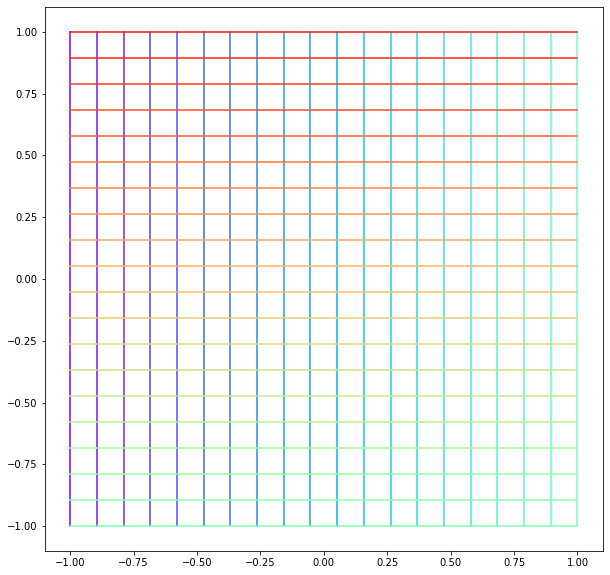

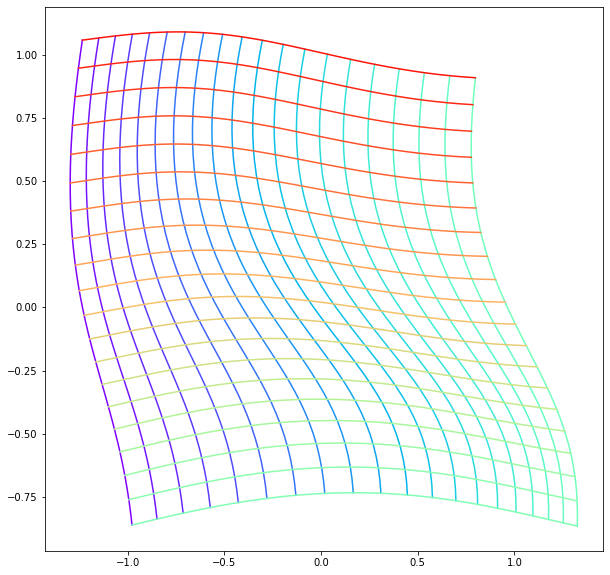

In [10]:
v = 0.05 * np.random.randn(D)

show_v(v)


la cloche originale


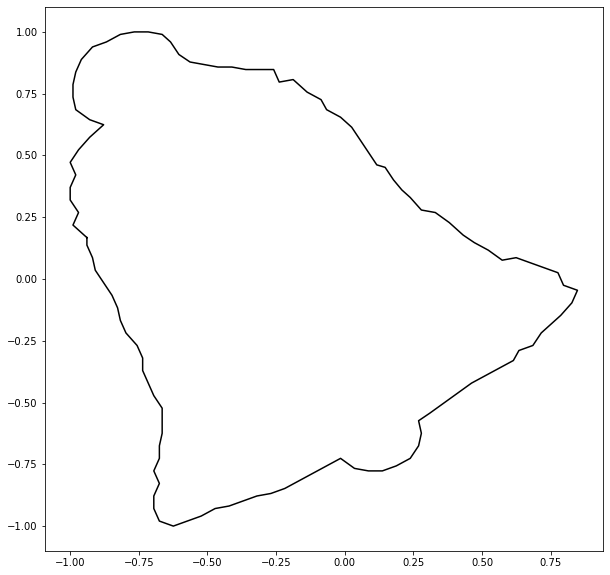

la cloche déformée par le v plus haut


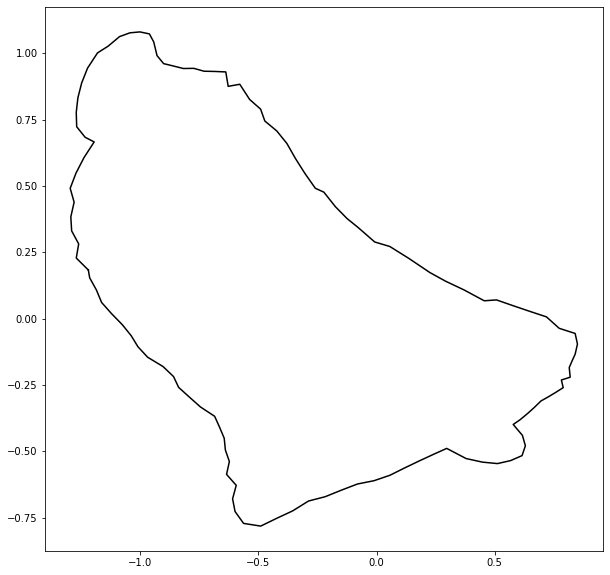

La distance de Hausdorff entre les deux = 0.3198499827816287
----
le chapeau original


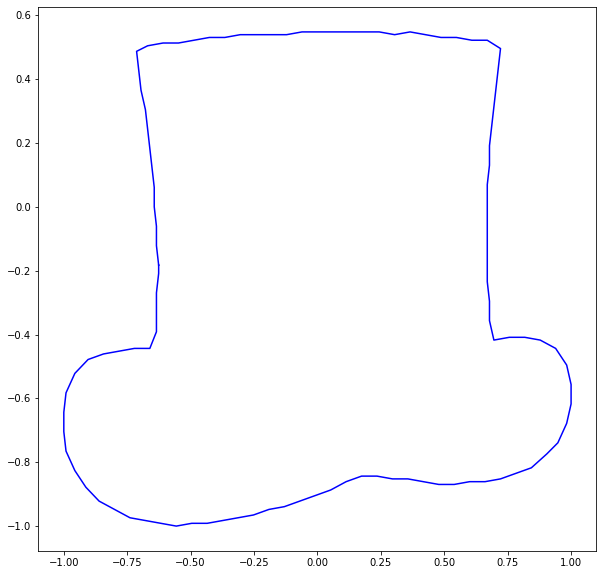

le chapeau déformé par le v plus haut


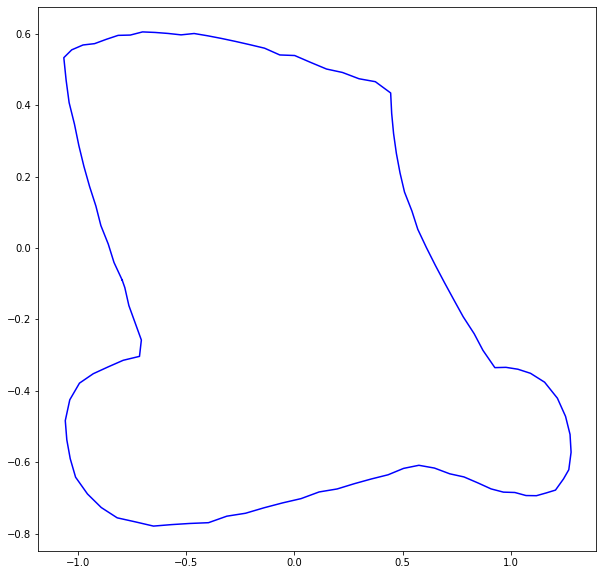

La distance de Hausdorff entre les deux = 0.3539406661757861


In [11]:

S = bell_points
print("la cloche originale")
show_points(S, '-k')

T = phi_array(v, S)

print("la cloche déformée par le v plus haut")
show_points(T, '-k')

print("La distance de Hausdorff entre les deux =", hausdorff_distance(S, T))
print("----")

S = hat_points
print("le chapeau original")
show_points(S, '-b')

T = phi_array(v, S)

print("le chapeau déformé par le v plus haut")
show_points(T, '-b')

print("La distance de Hausdorff entre les deux =", hausdorff_distance(S, T))


On applique maintenant l'algorithme de descente de gradient pour minimiser la fonctionelle J.

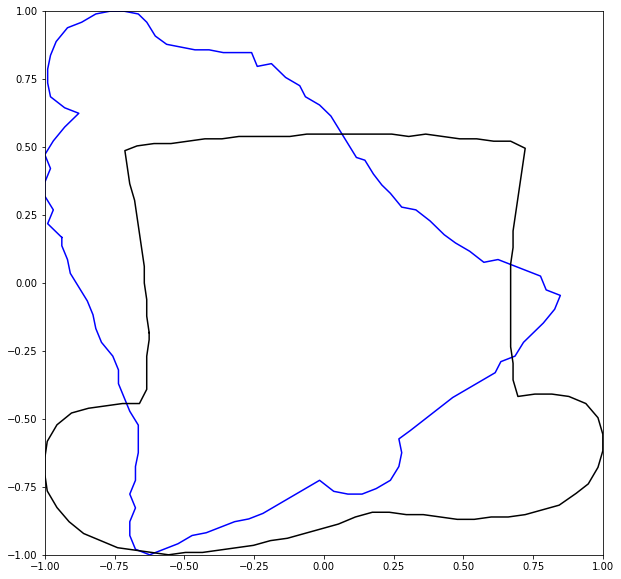

In [12]:
v0 = [0.0] * D

S = bell_points
T = hat_points
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlim=(-1, 1), ylim=(-1, 1))
plt.plot(*zip(*S), '-b')
plt.plot(*zip(*T), '-k')
plt.show()


[GD] pass =  0 ; value = 0.535959782506113
done in 23.829618453979492 seconds
[GD] pass =  1 ; value = 0.49613052401030483
done in 22.76916265487671 seconds
[GD] pass =  2 ; value = 0.4869534970126628
done in 23.34840440750122 seconds
[GD] pass =  3 ; value = 0.47945169132635723
done in 23.935378789901733 seconds
[GD] pass =  4 ; value = 0.47859403741705014
done in 23.358144521713257 seconds
[GD] pass =  5 ; value = 0.47153623292238517
done in 24.792784452438354 seconds
[GD] pass =  6 ; value = 0.4599486482911896
done in 23.476783275604248 seconds
[GD] pass =  7 ; value = 0.4491736172572739
done in 21.894391298294067 seconds
[GD] pass =  8 ; value = 0.42967338785966563
done in 23.507323741912842 seconds
[GD] pass =  9 ; value = 0.41024742079830673
done in 25.954730987548828 seconds
[GD] pass =  10 ; value = 0.37890278616864126
done in 24.269256830215454 seconds
[GD] pass =  11 ; value = 0.36788824665796666
done in 26.68348503112793 seconds
[GD] pass =  12 ; value = 0.367634872379153
do

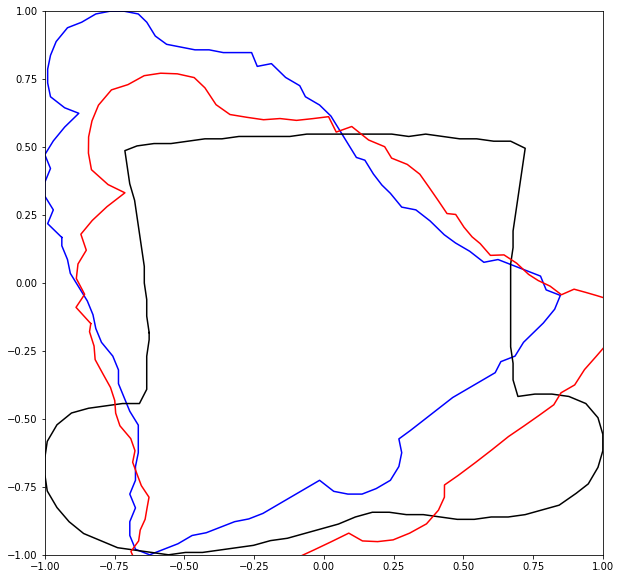

In [13]:
v0 = [0.0] * D
it = 20
best_v = gradient_descent(lambda x: J(x, S, T) , start=v0, dim=D, iterations=it, learning_rate_guess=1.,print_value=True);

print("---")
print("after", it, "iterations")
print("J(best_v)=", J(best_v, S, T))

result = phi_array(best_v, S)
print("Dist(phi_v(S), T)=", hausdorff_distance(T, result))
print("norm(v)=", np.linalg.norm(best_v))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlim=(-1, 1), ylim=(-1, 1))
plt.plot(*zip(*S), '-b')
plt.plot(*zip(*T), '-k')
plt.plot(*zip(*result), '-r')
plt.show()

Le temps de calcul est élevé mais le résultat est encourageant.

À faire :
 - optimiser le temps de calcul. Deux solutions : une attache aux données plus simple et un cacul explicite du gradient, ou la différentiation automatique de `pytorch` en utilisant une approximation lisse du max $$m(x,y) = \frac{x + y - \sqrt{(x-y)^2 + \varepsilon}}{2}$$
 - cela permettre de jouer avec les paramètres : plus de points, plus d'itérations, écart-type différent...